In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from src.datasets.synthetic import SyntheticDataset2D

n_samples = 25
n_features = 2
interval = (-2, 2)

dataset = SyntheticDataset2D(n_samples, n_features, interval)

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

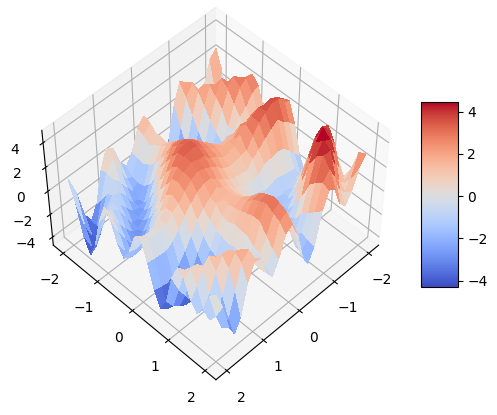

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(dataset.xv, dataset.yv, dataset.y.reshape(n_samples, n_samples), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(50, 45)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [6]:
import torch
from torch.utils.data import random_split

In [7]:
ds_train, ds_test = random_split(dataset, [0.8, 0.2])

In [10]:
from src.models.mlp import MLP
from torchinfo import summary

model = MLP(input_size=n_features, hidden_size=10, output_size=1, n_layers=3)
summary(model, input_size=(1, n_features))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Sequential: 2-1                   [1, 10]                   --
│    │    └─Linear: 3-1                  [1, 10]                   30
│    │    └─ReLU: 3-2                    [1, 10]                   --
│    └─Sequential: 2-2                   [1, 10]                   --
│    │    └─Linear: 3-3                  [1, 10]                   110
│    │    └─ReLU: 3-4                    [1, 10]                   --
│    └─Sequential: 2-3                   [1, 10]                   --
│    │    └─Linear: 3-5                  [1, 10]                   110
│    │    └─ReLU: 3-6                    [1, 10]                   --
│    └─Linear: 2-4                       [1, 1]                    11
Total params: 261
Trainable params: 261
Non-trainable params: 0
Total mult-adds (M)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print(f"Using device: {device}")
print(f"Training on {len(ds_train)} samples")
print(f"Testing on {len(ds_test)} samples")

Using device: cuda
Training on 500 samples
Testing on 125 samples


In [13]:
from torch.utils.data import DataLoader

train_dl = DataLoader(ds_train, batch_size=4, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=4, shuffle=False)

In [14]:
epochs = 100
lr = 0.01
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epochs):
    model.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            test_loss += criterion(y_pred, y)
        print(f"Epoch {e+1}/{epochs}, Test loss: {test_loss/len(test_dl)}")

Epoch 1/100, Test loss: 2.724719285964966
Epoch 2/100, Test loss: 2.4988677501678467
Epoch 3/100, Test loss: 2.38905668258667
Epoch 4/100, Test loss: 2.409660577774048
Epoch 5/100, Test loss: 2.3045990467071533
Epoch 6/100, Test loss: 2.483447313308716
Epoch 7/100, Test loss: 2.217583179473877
Epoch 8/100, Test loss: 2.1868484020233154
Epoch 9/100, Test loss: 2.4518561363220215
Epoch 10/100, Test loss: 2.0912222862243652
Epoch 11/100, Test loss: 2.1460680961608887
Epoch 12/100, Test loss: 2.275430202484131
Epoch 13/100, Test loss: 2.2317135334014893
Epoch 14/100, Test loss: 2.386979818344116
Epoch 15/100, Test loss: 2.110380172729492
Epoch 16/100, Test loss: 2.4239892959594727
Epoch 17/100, Test loss: 2.0268123149871826
Epoch 18/100, Test loss: 2.087355613708496
Epoch 19/100, Test loss: 1.9380807876586914
Epoch 20/100, Test loss: 1.9327480792999268
Epoch 21/100, Test loss: 1.8654242753982544


KeyboardInterrupt: 

In [97]:
z_pred = model(dataset.x.to(device)).cpu()
z_pred = z_pred.detach().numpy().reshape(n_samples, n_samples)

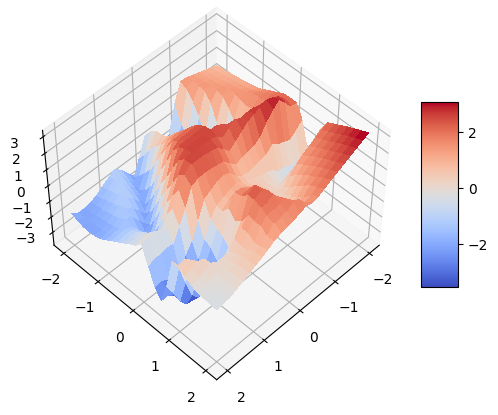

In [98]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(dataset.xv, dataset.yv, z_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(50, 45)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [17]:
def constantLR(epochs, eta, loader_length):
    return np.full(epochs * loader_length, eta)

def cosineLR(epochs, eta_min, eta_max, loader_length):
    T_max = epochs * loader_length
    steps = np.arange(0, T_max)

    lr = eta_min + 0.5 * (eta_max - eta_min) * (
        1
        + np.cos(steps / T_max * np.pi)
    )

    return lr

def linearLR(epochs, eta_min, eta_max, loader_length):
    steps = np.arange(0, epochs * loader_length)

    lr = eta_max + (eta_min - eta_max) * steps / (epochs * loader_length)

    return lr

def swaLinearLR(epochs, eta_min, eta_max, loader_length, swa_epoch_length):
    steps = np.arange(0, swa_epoch_length * loader_length)

    lr_swa = eta_max + (eta_min - eta_max) * steps / (swa_epoch_length * loader_length)
    lr = np.tile(lr_swa, epochs // swa_epoch_length)

    return lr

def swaCosineLR(epochs, eta_min, eta_max, loader_length, swa_epoch_length):
    T_max = swa_epoch_length * loader_length
    steps = np.arange(0, T_max)

    lr_swa = eta_min + 0.5 * (eta_max - eta_min) * (
        1
        + np.cos(steps / T_max * np.pi)
    )
    lr = np.tile(lr_swa, epochs // swa_epoch_length)

    return lr


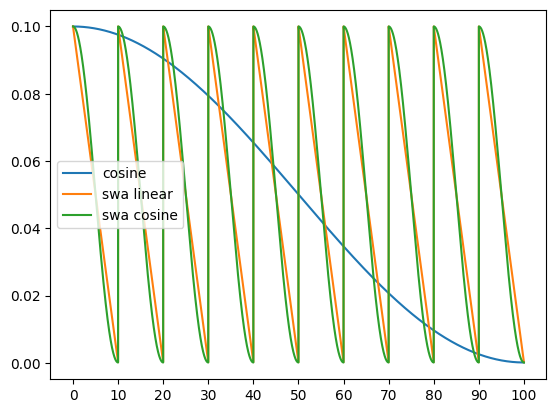

In [122]:
plt.plot(cosineLR(100, 0.0001, 0.1, 100), label="cosine")
plt.plot(swaLinearLR(100, 0.0001, 0.1, 100, 10), label="swa linear")
plt.plot(swaCosineLR(100, 0.0001, 0.1, 100, 10), label="swa cosine")
plt.legend()
plt.xticks(np.arange(0, 10001, 1000), np.arange(0, 101, 10))
plt.show()


In [160]:
model = MLP(n_input=n_features, n_hidden=10, n_output=1, n_layers=3).to(device)

epochs = 100
lr = 0.01
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = linearLR(epochs, 0.0001, 0.01, len(train_dl))

for e in range(epochs):
    model.train()
    for it, (x, y) in enumerate(train_dl):
        itx = it + e * len(train_dl)
        for param_group in optimizer.param_groups:
            param_group["lr"] = scheduler[itx]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            test_loss += criterion(y_pred, y)
        print(f"Epoch {e+1}/{epochs}, Test loss: {test_loss/len(test_dl)}")

Epoch 1/100, Test loss: 4.048849582672119
Epoch 2/100, Test loss: 3.2700231075286865
Epoch 3/100, Test loss: 3.084702253341675
Epoch 4/100, Test loss: 2.9949729442596436
Epoch 5/100, Test loss: 3.1559293270111084
Epoch 6/100, Test loss: 2.8518853187561035
Epoch 7/100, Test loss: 2.8169655799865723
Epoch 8/100, Test loss: 2.892540216445923
Epoch 9/100, Test loss: 2.8109216690063477
Epoch 10/100, Test loss: 2.7346749305725098
Epoch 11/100, Test loss: 2.9483609199523926
Epoch 12/100, Test loss: 2.754045009613037
Epoch 13/100, Test loss: 2.8672752380371094
Epoch 14/100, Test loss: 3.179069995880127
Epoch 15/100, Test loss: 2.451145648956299
Epoch 16/100, Test loss: 2.693687677383423
Epoch 17/100, Test loss: 2.8533496856689453
Epoch 18/100, Test loss: 2.5417587757110596
Epoch 19/100, Test loss: 2.7504677772521973
Epoch 20/100, Test loss: 2.5481905937194824
Epoch 21/100, Test loss: 3.081477642059326
Epoch 22/100, Test loss: 2.2363333702087402
Epoch 23/100, Test loss: 2.435750961303711
Epoch 

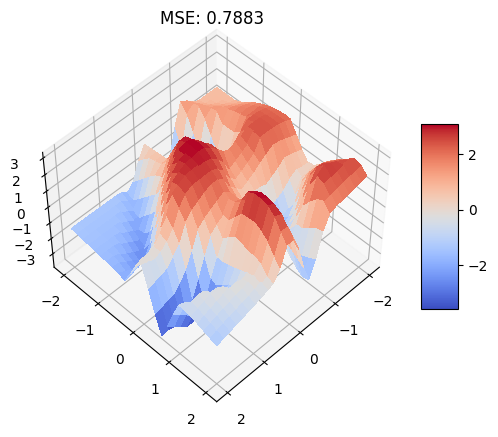

In [163]:
z_pred = model(dataset.x.to(device)).cpu()
z_pred = z_pred.detach().numpy().reshape(n_samples, n_samples)

mse = np.mean((z_pred - dataset.y.reshape(n_samples, n_samples).numpy())**2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(dataset.xv, dataset.yv, z_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(50, 45)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title(f"MSE: {mse:.4f}")
plt.show()

In [125]:
def update_swa(swa_model, model, n):
    for swa_param, param in zip(swa_model.parameters(), model.parameters()):
        swa_param.data = (swa_param.data * n + param.data.detach()) / (n + 1)

In [18]:
model = MLP(hidden_size=10, input_size=n_features, output_size=1, n_layers=3).to(device)
swaModel = MLP(hidden_size=10, input_size=n_features, output_size=1, n_layers=3).to(device)

epochs = 200
lr = 0.01
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
swa_n = 0
swa_length = 20
swa_start = 100
scheduler_train = constantLR(swa_start, 0.01, len(train_dl))
scheduler_swa = swaLinearLR(epochs, 0.0001, 0.01, len(train_dl), swa_length)
scheduler = np.concatenate((scheduler_train, scheduler_swa))


for e in range(epochs):
    model.train()
    for it, (x, y) in enumerate(train_dl):
        itx = it + e * len(train_dl)
        for param_group in optimizer.param_groups:
            param_group["lr"] = scheduler[itx]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    if e > swa_start and (e+1) % swa_length == 0:
        update_swa(swaModel, model, swa_n)
        swa_n += 1

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            test_loss += criterion(y_pred, y)
        print(f"Epoch {e+1}/{epochs}, Test loss: {test_loss/len(test_dl)}{' (SWA update)' if (e > swa_start and (e+1) % swa_length == 0) else ''}")

Epoch 1/200, Test loss: 2.8814499378204346
Epoch 2/200, Test loss: 2.533784866333008
Epoch 3/200, Test loss: 2.3908326625823975
Epoch 4/200, Test loss: 2.615440607070923
Epoch 5/200, Test loss: 2.3781545162200928
Epoch 6/200, Test loss: 2.374246597290039
Epoch 7/200, Test loss: 2.411973237991333
Epoch 8/200, Test loss: 2.391111373901367
Epoch 9/200, Test loss: 2.5764269828796387
Epoch 10/200, Test loss: 2.3776445388793945
Epoch 11/200, Test loss: 2.350569725036621
Epoch 12/200, Test loss: 2.2495782375335693
Epoch 13/200, Test loss: 2.170663833618164
Epoch 14/200, Test loss: 2.230417251586914
Epoch 15/200, Test loss: 2.3351614475250244
Epoch 16/200, Test loss: 2.203967571258545
Epoch 17/200, Test loss: 2.0846805572509766
Epoch 18/200, Test loss: 2.788137674331665
Epoch 19/200, Test loss: 2.0398905277252197
Epoch 20/200, Test loss: 1.8158259391784668
Epoch 21/200, Test loss: 1.976449966430664
Epoch 22/200, Test loss: 1.8740500211715698
Epoch 23/200, Test loss: 1.7969900369644165
Epoch 24

KeyboardInterrupt: 

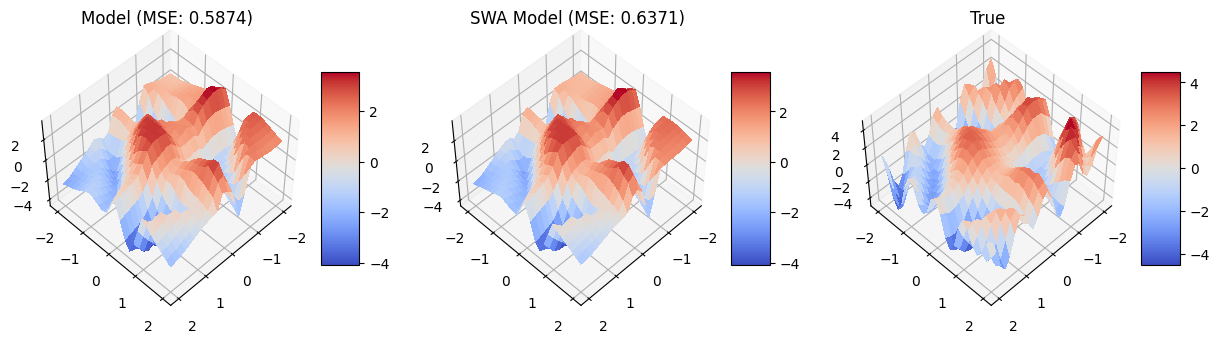

In [171]:
z_pred = model(dataset.x.to(device)).cpu()
z_pred = z_pred.detach().numpy().reshape(n_samples, n_samples)

z_pred_swa = swaModel(dataset.x.to(device)).cpu()
z_pred_swa = z_pred_swa.detach().numpy().reshape(n_samples, n_samples)

mse = criterion(model(dataset.x.to(device)), dataset.y.to(device)).item()
mse_swa = criterion(swaModel(dataset.x.to(device)), dataset.y.to(device)).item()

fig, ax = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(15, 5))
surf = ax[0].plot_surface(dataset.xv, dataset.yv, z_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[0].view_init(50, 45)
ax[0].set_title(f"Model (MSE: {mse:.4f})")
fig.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].plot_surface(dataset.xv, dataset.yv, z_pred_swa, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[1].view_init(50, 45)
ax[1].set_title(f"SWA Model (MSE: {mse_swa:.4f})")
fig.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[2].plot_surface(dataset.xv, dataset.yv, dataset.y.reshape(n_samples, n_samples), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax[2].view_init(50, 45)
ax[2].set_title("True")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [8]:
from src.datasets import MNISTDataset

mnist_train = MNISTDataset(train=True)
mnist_test = MNISTDataset(train=False)

In [3]:
mnist_test[0][0].shape

torch.Size([1, 28, 28])

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from src.models import CNN
from torchinfo import summary

model = CNN(input_size=1, output_size=10, hidden_size=64, n_layers=3).to(device)
summary(model, input_size=(1, 1, 28, 28))

TypeError: super(type, obj): obj must be an instance or subtype of type

In [9]:
input_test = mnist_test[0][0].unsqueeze(0).to(device)



In [10]:
model(input_test)

torch.Size([1, 16, 7, 7])
torch.Size([1, 16, 1, 1])
torch.Size([1, 16])


tensor([[ 0.0007, -0.0311, -0.2159,  0.1371, -0.0155,  0.0173, -0.1083,  0.0665,
         -0.0384, -0.0562]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
train_dl = DataLoader(mnist_train, batch_size=32, shuffle=True)



In [10]:
input_size = 1
n_layers = 2

In [13]:
[[(input_size * 2 ** (i * 2), input_size * 2 ** ((i * 2) + 1)), (input_size * 2 ** ((i * 2) + 1), input_size * 2 ** ((i * 2) + 2))] for i in range(n_layers)]


[[(1, 2), (2, 4)], [(4, 8), (8, 16)]]